In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
import random
import gymnasium as gym
import highway_env
import collections
import os
from configuration2 import config_dict

In [11]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return states, actions, rewards.reshape(-1, 1), next_states, dones.reshape(-1, 1)
    
    def __len__(self):
        return len(self.buffer)

In [12]:
class Actor:
    def __init__(self, state_dim, action_dim, action_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.model = self._build_network()
        self.optimizer = optimizers.Adam(learning_rate=0.0001)
    
    def _build_network(self):
        inputs = layers.Input(shape=self.state_dim)
        
        # Aplatir l'entrée si elle est multidimensionnelle (comme une grille d'occupation)
        x = layers.Flatten()(inputs)
        
        # Couches cachées
        x = layers.Dense(400, activation='relu')(x)
        x = layers.Dense(300, activation='relu')(x)
        
        # Couche de sortie avec activation tanh pour borner les actions entre -1 et 1
        outputs = layers.Dense(self.action_dim, activation='tanh')(x)
        outputs = layers.Lambda(lambda x: x * self.action_bound)(outputs)
        
        model = models.Model(inputs, outputs)
        return model
    
    def predict(self, state):
        return self.model(state)
    
    def train(self, states, critic_grads):
        with tf.GradientTape() as tape:
            actions = self.model(states)
        actor_grads = tape.gradient(actions, self.model.trainable_variables, -critic_grads)
        self.optimizer.apply_gradients(zip(actor_grads, self.model.trainable_variables))

In [13]:
class Critic:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.model = self._build_network()
        self.optimizer = optimizers.Adam(learning_rate=0.001)
    
    def _build_network(self):
        # Entrée d'état
        state_input = layers.Input(shape=self.state_dim)
        state_out = layers.Flatten()(state_input)
        state_out = layers.Dense(400, activation='relu')(state_out)
        
        # Entrée d'action
        action_input = layers.Input(shape=(self.action_dim,))
        action_out = layers.Dense(300, activation='relu')(action_input)
        
        # Combiner les deux flux
        concat = layers.Concatenate()([state_out, action_out])
        x = layers.Dense(300, activation='relu')(concat)
        outputs = layers.Dense(1)(x)  # Q-valeur
        
        model = models.Model([state_input, action_input], outputs)
        return model
    
    def predict(self, state, action):
        return self.model([state, action])
    
    def train(self, states, actions, target_q):
        with tf.GradientTape() as tape:
            q_values = self.model([states, actions], training=True)
            loss = tf.math.reduce_mean(tf.math.square(target_q - q_values))
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    
    def get_action_gradients(self, states, actions):
        with tf.GradientTape() as tape:
            tape.watch(actions)
            q_values = self.model([states, actions])
        return tape.gradient(q_values, actions)

In [14]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, action_bound, buffer_capacity=100000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.gamma = 0.99  # facteur d'actualisation
        self.tau = 0.001  # taux de mise à jour soft pour les réseaux cibles
        
        # Réseaux principaux
        self.actor = Actor(state_dim, action_dim, action_bound)
        self.critic = Critic(state_dim, action_dim)
        
        # Réseaux cibles
        self.target_actor = Actor(state_dim, action_dim, action_bound)
        self.target_critic = Critic(state_dim, action_dim)
        
        # Initialiser les poids des réseaux cibles
        self.update_target_networks(tau=1.0)
        
        self.noise_std = 0.2  # écart-type pour le bruit d'exploration
        self.noise_decay = 0.9999  # facteur de décroissance du bruit
        self.min_noise = 0.01  # valeur minimale du bruit
    
    def update_target_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        
        # Mise à jour des poids du target_actor
        for source, target in zip(self.actor.model.variables, self.target_actor.model.variables):
            target.assign((1 - tau) * target + tau * source)
        
        # Mise à jour des poids du target_critic
        for source, target in zip(self.critic.model.variables, self.target_critic.model.variables):
            target.assign((1 - tau) * target + tau * source)
    
    def get_action(self, state, add_noise=True):
        state = np.expand_dims(state, axis=0).astype(np.float32)
        action = self.actor.predict(state)[0]
        
        if add_noise:
            noise = np.random.normal(0, self.noise_std, size=self.action_dim)
            action = np.clip(action + noise, -self.action_bound, self.action_bound)
            # Réduire le bruit au fil du temps
            self.noise_std = max(self.min_noise, self.noise_std * self.noise_decay)
        
        return action
    
    def remember(self, state, action, reward, next_state, done):
        self.buffer.add(state, action, reward, next_state, done)
    
    def train(self):
        if len(self.buffer) < self.batch_size:
            return
        
        # Échantillonner un batch d'expériences
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        
        # Convertir en tenseurs TensorFlow
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        # Entraîner le critique
        target_actions = self.target_actor.predict(next_states)
        target_q = self.target_critic.predict(next_states, target_actions)
        target_q = rewards + self.gamma * target_q * (1 - dones)
        
        critic_loss = self.critic.train(states, actions, target_q)
        
        # Entraîner l'acteur
        actions_pred = self.actor.predict(states)
        critic_grads = self.critic.get_action_gradients(states, actions_pred)
        self.actor.train(states, critic_grads)
        
        # Mettre à jour les réseaux cibles
        self.update_target_networks()
        
        return critic_loss

In [15]:
def train_ddpg(env, agent, episodes=1000, max_steps_per_episode=300, render_interval=10):
    episode_rewards = []
    episode_steps = []
    best_reward = -float('inf')
    
    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False
        step = 0
        
        # Pour visualisation
        render = (episode % render_interval == 0)
        frames = []
        
        while not (done or truncated) and step < max_steps_per_episode:
            # Sélectionner une action
            action = agent.get_action(state)
            
            # Exécuter l'action
            next_state, reward, done, truncated, _ = env.step(action)
            
            # Stocker l'expérience
            agent.remember(state, action, reward, next_state, done or truncated)
            
            # Entraîner l'agent
            agent.train()
            
            # Mise à jour de l'état et du compteur
            state = next_state
            episode_reward += reward
            step += 1
            
            # Capturer une image pour le rendu
            if render:
                frames.append(env.render())
        
        episode_rewards.append(episode_reward)
        episode_steps.append(step)
        
        # Afficher la progression
        if episode % 10 == 0:
            clear_output(wait=True)
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Épisode {episode}, Moyenne des 10 dernières récompenses: {avg_reward:.2f}, Bruit: {agent.noise_std:.4f}")
            
            # Tracer la courbe de récompense
            plt.figure(figsize=(10, 5))
            plt.plot(episode_rewards)
            plt.title('Récompense par épisode')
            plt.xlabel('Épisode')
            plt.ylabel('Récompense')
            plt.grid(True)
            plt.show()
        
        # Si c'est un épisode de rendu, afficher l'animation
        if render and frames:
            print(f"Rendu de l'épisode {episode}, Récompense: {episode_reward:.2f}, Étapes: {step}")
            plt.figure(figsize=(8, 8))
            for i, frame in enumerate(frames):
                if i % 5 == 0:  # Afficher une image sur 5 pour accélérer
                    plt.clf()
                    plt.imshow(frame)
                    plt.axis('off')
                    plt.title(f"Étape {i}, Récompense cumulée: {episode_reward:.2f}")
                    display(plt.gcf())
                    clear_output(wait=True)
                    time.sleep(0.01)
            plt.close()
        
        # Sauvegarder le meilleur modèle
        if episode_reward > best_reward:
            best_reward = episode_reward
            # Sauvegarde des modèles (à décommenter si nécessaire)
            # agent.actor.model.save_weights('best_actor.h5')
            # agent.critic.model.save_weights('best_critic.h5')
    
    return episode_rewards, episode_steps

In [16]:
# Créer et configurer l'environnement
config_dict["offscreen_rendering"] = True
config_dict["render_mode"] = "rgb_array"

gym.register_envs(highway_env)
env = gym.make("racetrack-v0", render_mode="rgb_array")
env.unwrapped.configure(config_dict)

# Observer les dimensions de l'état et de l'action
state, _ = env.reset()
print(f"Forme de l'observation: {state.shape}")
print(f"Espace d'action: {env.action_space}")

# Définir les dimensions d'état et d'action
state_dim = state.shape
action_dim = env.action_space.shape[0]  # Devrait être 1 pour le contrôle latéral
action_bound = 1.0  # Les actions sont normalisées entre -1 et 1

# Créer l'agent DDPG
agent = DDPGAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    action_bound=action_bound,
    buffer_capacity=50000,
    batch_size=64
)

print(f"Agent créé avec state_dim={state_dim}, action_dim={action_dim}, action_bound={action_bound}")

Forme de l'observation: (2, 12, 12)
Espace d'action: Box(-1.0, 1.0, (1,), float32)
Agent créé avec state_dim=(2, 12, 12), action_dim=1, action_bound=1.0


Épisode 30, Moyenne des 10 dernières récompenses: 223.02, Bruit: 0.0958


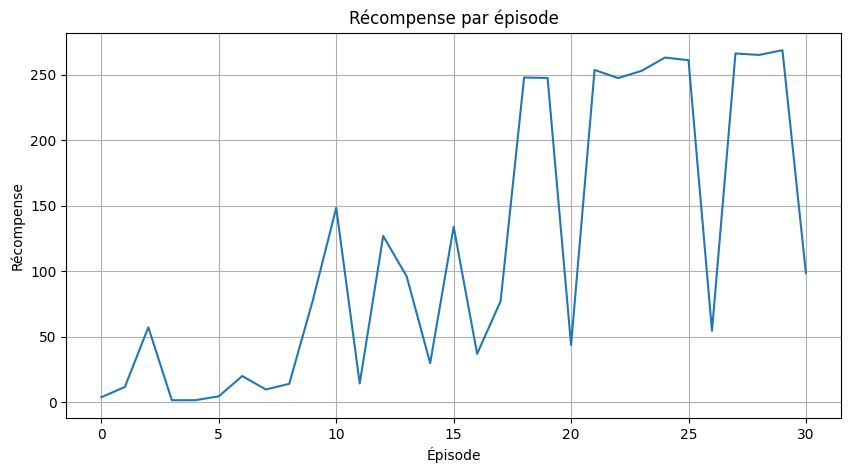

KeyboardInterrupt: 

: 

In [ ]:
# Paramètres d'entraînement
episodes = 300  # Nombre total d'épisodes d'entraînement
max_steps = 300  # Nombre maximum d'étapes par épisode

# Entraîner l'agent
rewards, steps = train_ddpg(
    env=env,
    agent=agent,
    episodes=episodes,
    max_steps_per_episode=max_steps,
    render_interval=300,  # Intervalle de rendu (0 pour désactiver)
)

NameError: name 'rewards' is not defined

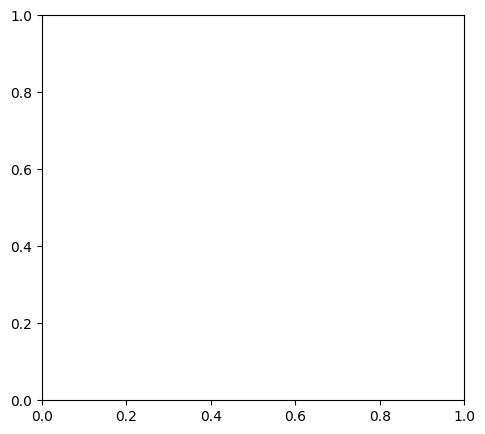

In [ ]:
# Tracer les courbes de récompense et d'étapes
plt.figure(figsize=(12, 5))

# Courbe de récompense
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Récompense par épisode')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.grid(True)

# Courbe du nombre d'étapes
plt.subplot(1, 2, 2)
plt.plot(steps)
plt.title('Nombre d\'étapes par épisode')
plt.xlabel('Épisode')
plt.ylabel('Étapes')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculer et afficher les moyennes glissantes
window_size = 10
rewards_smooth = [np.mean(rewards[max(0, i-window_size):i+1]) for i in range(len(rewards))]

plt.figure(figsize=(10, 5))
plt.plot(rewards, alpha=0.3, label='Récompenses brutes')
plt.plot(rewards_smooth, label='Moyenne glissante')
plt.title('Récompense par épisode (avec moyenne glissante)')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def evaluate_agent(env, agent, episodes=5, render=True):
    total_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False
        frames = []
        step = 0
        
        while not (done or truncated) and step < 300:
            # Choisir l'action sans bruit
            action = agent.get_action(state, add_noise=False)
            
            # Exécuter l'action
            next_state, reward, done, truncated, _ = env.step(action)
            
            # Mettre à jour l'état et la récompense
            state = next_state
            episode_reward += reward
            step += 1
            
            # Capturer le rendu
            if render:
                frames.append(env.render())
        
        total_rewards.append(episode_reward)
        print(f"Épisode d'évaluation {episode+1}/{episodes}, Récompense: {episode_reward:.2f}, Étapes: {step}")
        
        # Afficher le rendu
        if render and frames:
            plt.figure(figsize=(8, 8))
            for i, frame in enumerate(frames):
                if i % 5 == 0:  # Afficher une image sur 5 pour accélérer
                    plt.clf()
                    plt.imshow(frame)
                    plt.axis('off')
                    plt.title(f"Étape {i}, Récompense cumulée: {episode_reward:.2f}")
                    display(plt.gcf())
                    clear_output(wait=True)
                    time.sleep(0.01)
            plt.close()
    
    avg_reward = np.mean(total_rewards)
    print(f"Récompense moyenne sur {episodes} épisodes: {avg_reward:.2f}")
    return avg_reward

# Évaluer l'agent entraîné
evaluate_agent(env, agent, episodes=3, render=True)

KeyboardInterrupt: 